## Task Introduction
In the traditional machine learning domain, building robust and meaningful features can significantly improve final model performance. As a result, in this notebook, I intend to demonstrate the capability of this package on the automated future construction. For the sake of simplicity, I chose a problem from the scikit-learn package as the case study problem. The task is called "diabetes," and its goal is to predict a quantitative measure of disease progression one year after baseline. First, we split the data into a training and a testing set, then train a random forest and an evolutionary forest separately and test them on the testing set.


In [13]:
import random

import numpy as np
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.datasets import load_diabetes
from sklearn.ensemble import ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

from evolutionary_forest.forest import EvolutionaryForestRegressor
from evolutionary_forest.utils import get_feature_importance, plot_feature_importance, feature_append

random.seed(0)
np.random.seed(0)

# Load Dataset
X, y = load_diabetes(return_X_y=True)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [14]:
# Train Random Forest
r = RandomForestRegressor()
r.fit(x_train, y_train)
print(r2_score(y_test, r.predict(x_test)))

# Train Evolutionary Forest
r = EvolutionaryForestRegressor(max_height=3, normalize=True, select='AutomaticLexicase',
                                gene_num=10, boost_size=100, n_gen=20, n_pop=200, cross_pb=1,
                                base_learner='Random-DT', verbose=True, n_process=64)
r.fit(x_train, y_train)
print(r2_score(y_test, r.predict(x_test)))

0.26491330931789137
   	      	                                fitness                                	                      size                     
   	      	-----------------------------------------------------------------------	-----------------------------------------------
gen	nevals	avg     	gen	max     	min      	nevals	std    	avg  	gen	max	min	nevals	std    
0  	200   	0.189537	0  	0.756794	-0.109425	200   	0.14257	42.52	0  	60 	30 	200   	5.25448
1  	200   	0.168211	1  	0.656472	-0.133597	200   	0.148955	42.51	1  	56 	32 	200   	4.74973
2  	200   	0.151991	2  	0.590744	-0.15222 	200   	0.134883	43.14	2  	58 	32 	200   	4.66266
3  	200   	0.138776	3  	0.678939	-0.1583  	200   	0.136136	43.26	3  	58 	30 	200   	4.7384 
4  	200   	0.114721	4  	0.464724	-0.115243	200   	0.123345	43.43	4  	60 	28 	200   	4.95733
5  	200   	0.114155	5  	0.540119	-0.129526	200   	0.113364	43.28	5  	60 	28 	200   	5.66759
6  	200   	0.102587	6  	0.40471 	-0.11786 	200   	0.109651	43.77	6  	60 	28 

## Feature Importance Visualization
Based on this result, we can see that the evolutionary forest outperforms the traditional random forest. However, we should not be satisfied with simply having a better model. In fact, a more important goal is to obtain more explainable features, which can improve the performance of many machine learning models. As a result, in the section that follows, we calculate our future importance based on impurity reduction and then rank all features based on those importance scores. For clarity, our package will only display the top 15 most important features.


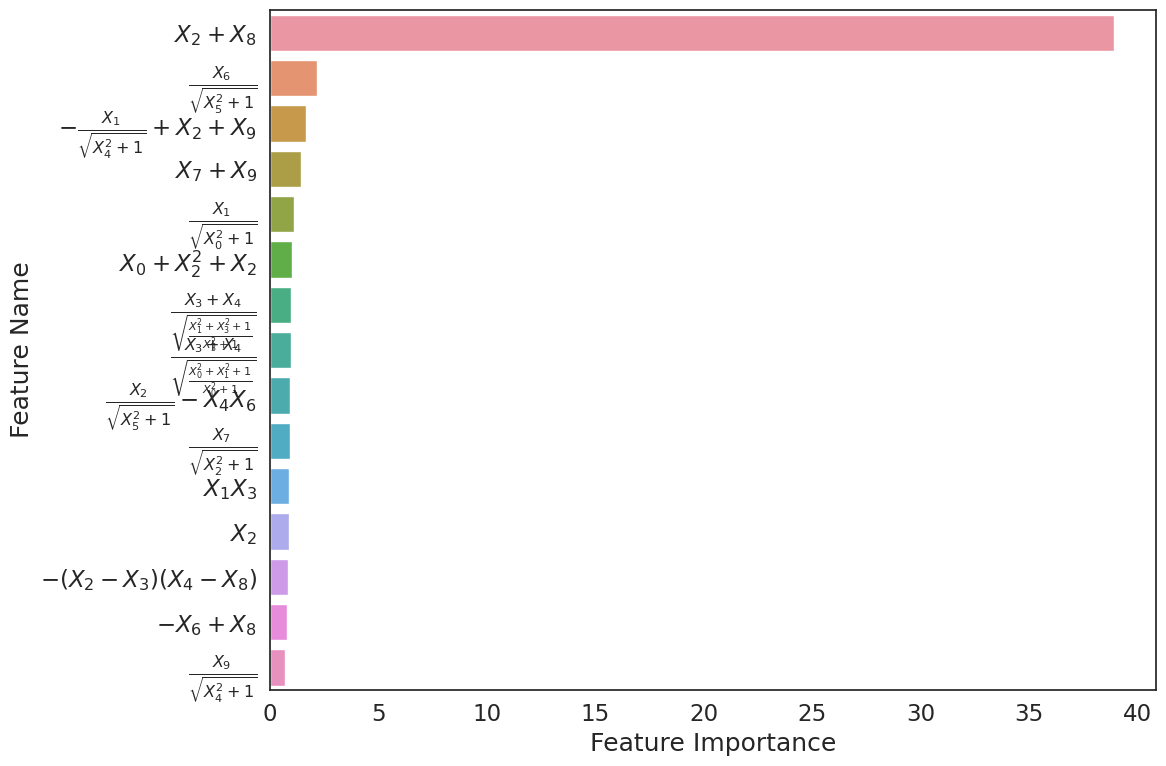

In [15]:
# Calculate feature importance values
feature_importance_dict = get_feature_importance(r)
plot_feature_importance(feature_importance_dict)

Following the creation of the importance map, we may be able to leverage those useful features in the following section and investigate whether those features can truly improve the performance of an existing model. For the sake of simplicity, we abandoned the use of the original features and only retained the constructed features.

In [16]:
# Synthesize new features
code_importance_dict = get_feature_importance(r, simple_version=False)
new_train = feature_append(r, r.x_scaler.transform(x_train),
                           list(code_importance_dict.keys())[:len(code_importance_dict) // 2],
                           only_new_features=True)
new_test = feature_append(r, r.x_scaler.transform(x_test),
                          list(code_importance_dict.keys())[:len(code_importance_dict) // 2],
                          only_new_features=True)
# Train a new model based on synthesized features
new_r = RandomForestRegressor()
new_r.fit(new_train, y_train)
print(r2_score(y_test, new_r.predict(new_test)))

0.2868234236333319


## Further Investigation of Feature Construction
As we can see from the results, the constructed features can effectively lead to improved performance, demonstrating the effectiveness of constructed features. However, a more interesting question is whether these features can only be used on this model or if they can also be applied to other machine learning models. So, in the following section, we try to see if the features constructed by EF can be used to improve the performance of existing state-of-the-art machine learning systems.

In [17]:
from pathos.multiprocessing import ProcessPool
import pandas as pd
from sklearn.model_selection import KFold

def single_fold_training(train_index, test_index):
    regressor_list = ['RF', 'ET', 'AdaBoost', 'GBDT', 'DART', 'XGBoost', 'LightGBM', 'CatBoost']
    x_train, y_train, x_test, y_test = X[train_index], y[train_index], X[test_index], y[test_index]
    # Retrain an evolutionary forest
    r = EvolutionaryForestRegressor(max_height=3, normalize=True, select='AutomaticLexicase',
                                    gene_num=10, boost_size=100, n_gen=20, n_pop=200, cross_pb=1,
                                    base_learner='Random-DT', verbose=True, n_process=64)
    r.fit(x_train, y_train)
    # Testing data should also be normalized!
    x_train, x_test = r.x_scaler.transform(x_train), r.x_scaler.transform(x_test)
    # Synthesize new features
    code_importance_dict = get_feature_importance(r, simple_version=False)
    new_train = feature_append(r, x_train, list(code_importance_dict.keys())[:len(code_importance_dict.keys()) // 2],
                               only_new_features=True)
    new_test = feature_append(r, x_test, list(code_importance_dict.keys())[:len(code_importance_dict.keys()) // 2],
                              only_new_features=True)
    regressor_dict = {
        'RF': RandomForestRegressor(n_estimators=200, n_jobs=-1),
        'ET': ExtraTreesRegressor(n_estimators=200, n_jobs=-1),
        'AdaBoost': AdaBoostRegressor(n_estimators=200),
        'GBDT': GradientBoostingRegressor(n_estimators=200),
        'DART': LGBMRegressor(n_jobs=1, n_estimators=200, boosting_type='dart',
                              xgboost_dart_mode=True),
        'XGBoost': XGBRegressor(n_jobs=1, n_estimators=200),
        'LightGBM': LGBMRegressor(n_jobs=1, n_estimators=200),
        'CatBoost': CatBoostRegressor(n_estimators=200, thread_count=1,
                                      verbose=False, allow_writing_files=False),
    }
    scores_base = []
    scores_enhanced = []
    for regr in regressor_list:
        # Training on original features
        regressor = regressor_dict[regr]
        regressor.fit(x_train, y_train)
        score = r2_score(y_test, regressor.predict(x_test))
        base_score = (regr, score)
        scores_base.append(base_score)
        # Training on new features
        regressor.fit(new_train, y_train)
        score = r2_score(y_test, regressor.predict(new_test))
        enhanced_score = (regr, score)
        scores_enhanced.append(enhanced_score)
    return scores_base, scores_enhanced


p = ProcessPool()
cv = KFold(n_splits=10, shuffle=True, random_state=0)
scores_base = []
scores_enhanced = []
# Cross-validation through a multiprocess way
m = p.map(lambda x: single_fold_training(*x), cv.split(X, y))
for scores_base_tmp, scores_tmp in m:
    scores_base.extend(scores_base_tmp)
    scores_enhanced.extend(scores_tmp)

# Score aggregation
base_frame = pd.DataFrame(scores_base, columns=['algorithm', 'score'])
base_frame['score'] = pd.to_numeric(base_frame['score'])
print(base_frame.groupby(['algorithm']).mean())
improved_frame = pd.DataFrame(scores_enhanced, columns=['algorithm', 'score'])
improved_frame['score'] = pd.to_numeric(improved_frame['score'])
print(improved_frame.groupby(['algorithm']).mean())
base_score = base_frame.groupby(['algorithm']).mean()
improved_score = improved_frame.groupby(['algorithm']).mean()
print(improved_score - base_score)

              score
algorithm          
AdaBoost   0.422151
CatBoost   0.405567
DART       0.384715
ET         0.444923
GBDT       0.360907
LightGBM   0.358274
RF         0.416950
XGBoost    0.291273
              score
algorithm          
AdaBoost   0.431933
CatBoost   0.437168
DART       0.432814
ET         0.448991
GBDT       0.435842
LightGBM   0.423964
RF         0.477380
XGBoost    0.385388
              score
algorithm          
AdaBoost   0.009783
CatBoost   0.031601
DART       0.048100
ET         0.004069
GBDT       0.074935
LightGBM   0.065691
RF         0.060430
XGBoost    0.094114


## Improvement Visualization
As a result of this, we can conclude that constructive features improve the performance of all models. It specifically improves the performance of XGBoost and random forest. As a result of this experiment, we can conclude that our method can be used not only as an effective regression method for inducing a powerful regression model, but also as a feature construction method, which can be used to generate interpretable features and improve the performance of existing machine learning systems. The improvement caused by construction features is depicted in the figure below.

['g' 'g' 'g' 'g' 'g' 'g' 'g' 'g']


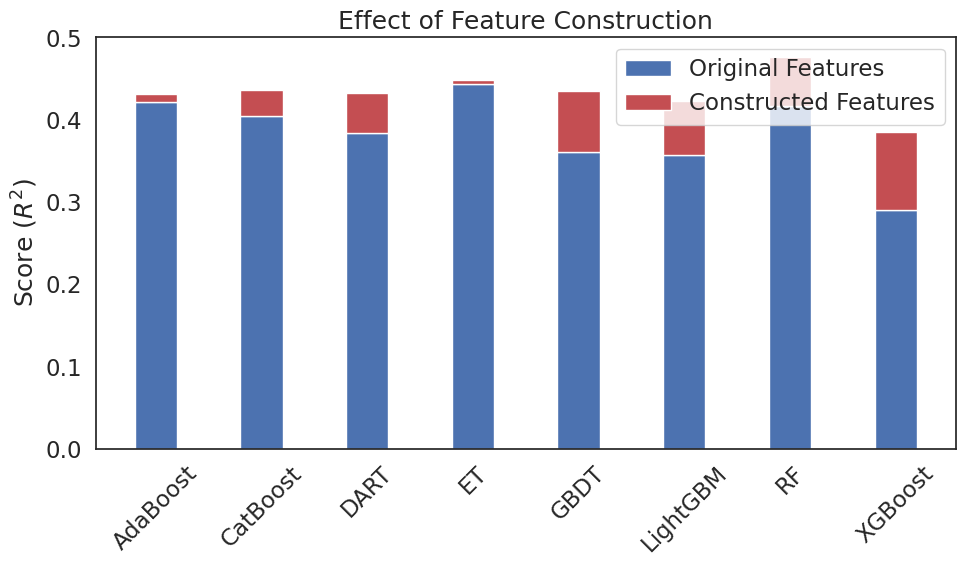

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="white", font_scale=1.5)
width = 0.4
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(base_score.index, base_score['score'], width, label='Original Features')
difference = improved_score['score'] - base_score['score']
print(np.where(difference > 0, 'g', 'y'))
ax.bar(base_score.index, difference, width, bottom=base_score['score'],
       label='Constructed Features',
       color=np.where(difference > 0, 'r', 'y'))
ax.set_ylabel('Score ($R^2$)')
ax.set_title('Effect of Feature Construction')
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Finally, we have shown that our method is capable of discovering useful features that can be used to improve existing machine learning systems. It should be noted, however, that even if the discovered features improve the validation score, there is a risk of overfitting. As a result, in real-world applications, it is recommended to investigate all used features to ensure the effectiveness of the newly constructed model.